[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/final/execution.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/ai-unibo-nlp-project/blob/main/final/execution.ipynb)
[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/Danysan1/ai-unibo-nlp-project/tree/main/final/execution.ipynb)

# Final project

## Imports and Initial Settings

In [1]:
%pip install pandas numpy matplotlib transformers dataset nltk onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.24
    Uninstalling SQLAlchemy-2.0.24:
      Successfully uninstalled SQLAlchemy-2.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.51 which is incompatible.


In [2]:
import numpy as np
import random
import torch
import pandas as pd
from os import path
from sklearn.model_selection import train_test_split
import random
import gc
import torch
import transformers
from tqdm import tqdm
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import nltk
import os
import json
#from eda import eda

In [3]:
# Fix the random state for reproducibility
SEED = 11

def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_seed(SEED)

## Dataset Loading

In [4]:
data_folder = 'Dataset'

def load__dataset(filename:str) -> pd.DataFrame:
    with open(path.join(data_folder, filename)) as file_obj:
        data = pd.read_json(file_obj, dtype={'episode':str,'speakers':np.array})
        return data

In [5]:
training_set_fn = 'MELD_train_efr.json'

dataset = load__dataset(training_set_fn)
dataset.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


In [6]:
def get_index_none_triggers(df:pd.DataFrame, column:str) -> list:
    has_none = []
    for i in df[column].index:
        is_none = np.where(np.array(df[column][i]) == None, 1, 0).any()
        if is_none:
            has_none.append(i)
    return has_none

def clean_none(df:pd.DataFrame, column:str, indexes:list) -> pd.DataFrame:
    for i in indexes:
        df[column][i] = [el if el is not None else 0.0 for el in df[column][i]]
    return df

Check how many triggers do have a None value.

In [7]:
indexes_none = get_index_none_triggers(dataset, column='triggers')
print("{} trigger rows have None values.\n".format(len(indexes_none)))
if len(indexes_none) > 0:
    print(dataset['triggers'][indexes_none])

9 trigger rows have None values.

2671                                [0.0, 0.0, 1.0, None]
2693                      [0.0, 0.0, 0.0, 0.0, 1.0, None]
3105    [0.0, 0.0, 0.0, None, 0.0, 0.0, 0.0, 1.0, 1.0,...
3157    [0.0, 0.0, None, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...
3171    [0.0, 0.0, 0.0, 0.0, 0.0, None, 0.0, 0.0, 1.0,...
3204    [None, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3266    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, None, 0.0, 1.0,...
3351    [0.0, 0.0, 0.0, None, 0.0, 0.0, 0.0, 0.0, 0.0,...
3359    [0.0, None, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: triggers, dtype: object


Now we clean the dataset and then check the previous lists.

In [8]:
dataset = clean_none(dataset, column='triggers', indexes=indexes_none)
indexes_none_clean = get_index_none_triggers(dataset, column='triggers')
print("\nAfter cleaning, {} trigger rows have None values.\n".format(len(indexes_none_clean)))
if len(indexes_none) > 0:
    print(dataset['triggers'][indexes_none])


After cleaning, 0 trigger rows have None values.

2671                                 [0.0, 0.0, 1.0, 0.0]
2693                       [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
3105    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...
3157    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
3171    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
3204    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3266    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
3351    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3359    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: triggers, dtype: object


##Data Elaboration

###Preprocessing

In [9]:
def input_preprocessing(dataset,his_num=2):
  '''
  Preprocessing of the dataset. The dialogues get splitted to create three columns:
  - utterance: the current sentence
  - history: the previous sentence(s)
  - future: the next sentence

  Args:
    dataset: Pandas.DataFrame
    his_num: number of concatenated sentences forming the history column

  Returns the preprocessed dataset.
  '''
  tot = len(dataset)
  data = []
  for r in range(tot):
    text = dataset['utterances'][r]
    em = dataset['emotions'][r]
    trig = dataset['triggers'][r]
    for i in range(0,len(text)):
      t = []
      history = []
      sentence = text[i]
      if (i-his_num < 0):
        for q in range(i):
          history.append(text[q])
      else:
        for q in range(i-his_num,i):
          history.append(text[q])
      if(i+1 < len(text)):
        future = text[i+1]
      else:
        future = ""
      #convert the list t into a string
      string = " ".join(map(str,history))
      data.append({
          'episode': dataset['episode'][r],
          'utterance': sentence,
          'history' : string,
          'future' : future,
          'emotion': em[i],
          'trigger': bool(trig[i])
        })
  data = pd.DataFrame(data)
  return data

In [10]:
his_num = 2
data = input_preprocessing(dataset,his_num)

Examples of splitted *utterances*.

In [11]:
dataset['utterances'][0]

["also I was the point person on my company's transition from the KL-5 to GR-6 system.",
 "You must've had your hands full.",
 'That I did. That I did.',
 "So let's talk a little bit about your duties.",
 'My duties?  All right.']

Examples of history sentences formed by two consecutive utterances.

In [12]:
list(data['history'][:10])

['',
 "also I was the point person on my company's transition from the KL-5 to GR-6 system.",
 "also I was the point person on my company's transition from the KL-5 to GR-6 system. You must've had your hands full.",
 "You must've had your hands full. That I did. That I did.",
 "That I did. That I did. So let's talk a little bit about your duties.",
 '',
 "also I was the point person on my company's transition from the KL-5 to GR-6 system.",
 "also I was the point person on my company's transition from the KL-5 to GR-6 system. You must've had your hands full.",
 "You must've had your hands full. That I did. That I did.",
 "That I did. That I did. So let's talk a little bit about your duties."]

In [13]:
len(data)

35000

**Emotions** distribution for the entire dataset.

<Axes: >

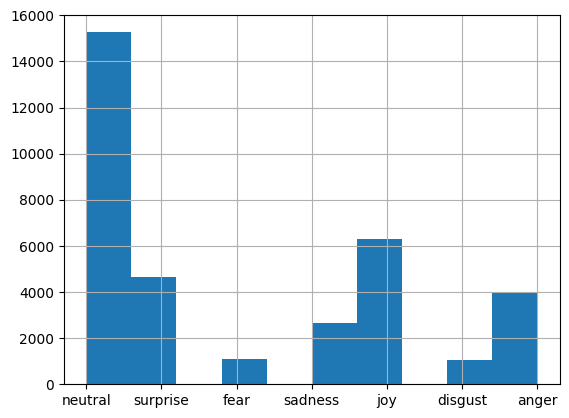

In [14]:
data['emotion'].hist()

This shows that the data is imbalanced.

In [15]:
episodes = data['episode'].unique() # list of episode names

###Label Encoder

In [16]:
#label encoder
from sklearn.preprocessing import LabelEncoder
le_emo = LabelEncoder()
data['labemo'] = le_emo.fit_transform(data['emotion'])
#le_tri = LabelEncoder()
#data['labtri'] = le_tri.fit_transform(data['trigger'])

In [17]:
data['emotion'].unique()

array(['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust',
       'anger'], dtype=object)

In [18]:
data['labemo'].unique()

array([4, 6, 2, 5, 3, 1, 0])

### Train-Val-Test splitting

Split the dataset into training (80%), validation (10%), and test set (10%).

In [19]:
idx_train, idx_test = train_test_split(episodes,
                                     random_state=SEED,
                                     test_size=0.1)
idx_train, idx_val = train_test_split(idx_train,
                                     random_state=SEED,
                                     test_size=idx_test.shape[0])
df_train = data[data['episode'].isin(idx_train)]
df_test = data[data['episode'].isin(idx_test)]
df_val = data[data['episode'].isin(idx_val)]
print('Number of training samples: {}'.format(df_train.shape[0]))
print('Number of test samples: {}'.format(df_test.shape[0]))
print('Number of validation examples: {}'.format(df_val.shape[0]))

Number of training samples: 27964
Number of test samples: 3517
Number of validation examples: 3519


In [20]:
df_train.head()

,episode,utterance,history,future,emotion,trigger,labemo
0,utterance_0,also I was the point person on my company's tr...,,You must've had your hands full.,neutral,False,4
1,utterance_0,You must've had your hands full.,also I was the point person on my company's tr...,That I did. That I did.,neutral,False,4
2,utterance_0,That I did. That I did.,also I was the point person on my company's tr...,So let's talk a little bit about your duties.,neutral,False,4
3,utterance_0,So let's talk a little bit about your duties.,You must've had your hands full. That I did. T...,My duties? All right.,neutral,True,4
4,utterance_0,My duties? All right.,That I did. That I did. So let's talk a little...,,surprise,False,6


In [21]:
df_test.head()

,episode,utterance,history,future,emotion,trigger,labemo
77,utterance_12,"Hey, Mon.",,Hey-hey-hey. You wanna hear something that sucks.,neutral,False,4
78,utterance_12,Hey-hey-hey. You wanna hear something that sucks.,"Hey, Mon.",Do I ever.,neutral,False,4
79,utterance_12,Do I ever.,"Hey, Mon. Hey-hey-hey. You wanna hear somethin...",Chris says they're closing down the bar.,joy,False,3
80,utterance_12,Chris says they're closing down the bar.,Hey-hey-hey. You wanna hear something that suc...,No way!,sadness,True,5
81,utterance_12,No way!,Do I ever. Chris says they're closing down the...,"Yeah, apparently they're turning it into some ...",surprise,False,6


### Easy Data Augmentation
The reference for this code is the following [paper](https://arxiv.org/abs/1901.11196). This is a previous attempt to use Easy Data Augmentation to balance the dataset with reference to the Trigger column. The augmentation is based only on rows showing a positive Trigger.

In [22]:
AUGMENT = False

if AUGMENT:
  nltk.download('wordnet')
  aug_test = eda("ok, i am not doing this", 0.2, 0.2, 0.2, 0.2, num_aug=2)
  print("Augmentation test for a single sentence: \n{}".format(aug_test))

  df = df_train[df_train['trigger']]

  ignore = ['utterance_1101', 'utterance_1753', 'utterance_2822']

  for i in ignore:
    df = df[df['episode'] != i]

  new_rows = []
  for i in range(len(df)):
      r = df.iloc[i].copy()
      #print(r['episode'])
      aug_utts = eda(r['utterance'],0.2,0.2,0.2,0.2, num_aug=4)
      aug_hist = eda(r['history'],0.2,0.2,0.2,0.2, num_aug=4) if r['history'] != "" else ""

      i = 0
      for ut in aug_utts:
          r['utterance'] = ut
          r['history'] = aug_hist[i] if r['history'] != "" else ""
          new_rows.append(r)

          r = r.copy()
          i += 1

  new_df = pd.DataFrame(new_rows)
  df_train = pd.concat([df_train,new_df]).reset_index(drop=True)
  df_train

## Utils

Create a folder for model's checkpoints.

In [23]:
models_dir = "models_{}".format(SEED)
bertfull_folder = os.path.join(models_dir, "full")
bertfreezed_folder = os.path.join(models_dir, "freezed")
if not os.path.exists(bertfull_folder):
    os.makedirs(bertfull_folder)
if not os.path.exists(bertfreezed_folder):
    os.makedirs(bertfreezed_folder)

#### Save and load results

In [24]:
results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

def results_to_csv(df_results,
                    seed):
    '''
    Args:
        df_results: DataFrame with the all the scores
        seed: the used seed
    '''
    csv_path = f"{results_folder}/{seed}.csv"
    df_results.to_csv(path_or_buf=csv_path)

In [25]:
def results_from_csv(seed,
                    ):
    '''
    Args:
        seed: the wanted seed
    '''
    file_path = f"results/{seed}.csv"
    df_results = pd.read_csv(file_path)

    return df_results

### Pytorch Dataset

In [26]:
class CreateDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

### Model

In [27]:
from transformers import DistilBertModel, BertModel
import torch.nn as nn

class CustomBERTModel(nn.Module):

      def __init__(self,checkpoint, num_labels_emo, num_labels_tri):
            super(CustomBERTModel, self).__init__()
            self.num_labels_emo = num_labels_emo
            self.num_labels_tri = num_labels_tri
            self.bert = BertModel.from_pretrained(checkpoint)
            ### New layers:
            self.dropout = nn.Dropout(0.3)
            self.cl1 = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
            self.relu = nn.ReLU()
            self.tanh = nn.Tanh()
            self.cls_emo = nn.Linear(self.bert.config.hidden_size, num_labels_emo)
            self.cls_tri = nn.Linear(self.bert.config.hidden_size, 1)

      def forward(self, input_ids, attention_mask):
            output = self.bert(
                  input_ids,
                  attention_mask=attention_mask,output_hidden_states=True )
            #sequence_output = output[0]
            #print(sequence_output.shape)
            #the pooler output (CLS token+dense+tanh) contains the information
            pooler_output = output.pooler_output
            #take the output of the last 4 hidden states of Bert
            output = torch.stack(output['hidden_states'][-4:])
            #compute the mean of the CLS token of the last 4 layers
            mean_pooler_output = torch.mean(torch.stack([output[layer_i,:,0,:] for layer_i in range(4)]),0)
            #print(mean_pooler_output.size())
            x = self.cl1(mean_pooler_output)
            x_emo = self.tanh(x)
            x_tri = self.relu(x)
            x_emo = self.dropout(x_emo)
            x_tri = self.dropout(x_tri)
            x_emo = self.cls_emo(x_emo)
            x_tri = self.cls_tri(x_tri)
            x_tri = torch.nn.functional.sigmoid(x_tri)
            return x_emo, x_tri

In [28]:
def getModel(model_checkpoint, num_labels_emo, num_labels_tri):
  '''
  Creates and return an instance of the desired model with the correct tokenizer.
  '''
  model = CustomBERTModel(model_checkpoint, num_labels_emo, num_labels_tri)
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)

  return model, tokenizer

### Training

In [29]:
# Train one epoch
def train(model: torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          device: torch.device,
          optimizer: torch.optim,
          criterion: list,
          epoch: int,
          trig_weight: float) -> float:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.
        optimizer: the optimizer to use to train the model.
        criterion: criterions used to calculate loss.
        epoch: the number of the current epoch.
        trig_weight: trigger loss multiplier.

    Returns:
        the cross entropy Loss value on the training data.
    """

    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)
    loss_score = []
    loop = tqdm(train_loader)
    #set training mode
    model.train()
    for idx_batch, batch in enumerate(loop):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_emo = batch['labels_emo'].to(device)
        labels_tri = batch['labels_tri'].to(device)
        #print(f"target-size: {labels.shape}")
        logits_emo, logits_tri = model(input_ids,
                                        attention_mask=attention_mask,
                                    )
        #print(f"logits-size: {logits.shape}")
        loss_emo = criterion[0](logits_emo, labels_emo)
        loss_tri = criterion[1](logits_tri, labels_tri)
        loss = loss_emo + trig_weight*loss_tri
        loss_score.append(loss.item())
        loss.backward()
        optimizer.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    loss_train = np.mean(loss_score)
    return loss_train

# Validate one epoch
def validate(model: torch.nn.Module,
             criterion: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             device: torch.device,
             trig_weight: float) -> float:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        criterion: criterions used to calculate loss.
        data_loader: the data loader containing the validation data.
        device: the device to use to evaluate the model.
        trig_weight: trigger loss multiplier.

    Returns:
        the loss value on the validation data.
    """
    loss_score = []
    #set evaluation mode
    model = model.eval()
    with torch.no_grad():
        for idx_batch, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_emo = batch['labels_emo'].to(device)
            labels_tri = batch['labels_tri'].to(device)
            logits_emo, logits_tri = model(input_ids,
                                            attention_mask=attention_mask,
                                        )
            loss_emo = criterion[0](logits_emo, labels_emo)
            loss_tri = criterion[1](logits_tri, labels_tri)
            loss = loss_emo + trig_weight*loss_tri
            loss_score.append(loss.item())
    loss_val = np.mean(loss_score)
    return loss_val

In [30]:
def training_loop(num_epochs: int,
                  optimizer: torch.optim,
                  criterion: torch.nn.Module,
                  model: torch.nn.Module,
                  loader_train: torch.utils.data.DataLoader,
                  loader_val : torch.utils.data.DataLoader = None,
                  model_dir = "models",
                  trig_weight = 1.0,
                  verbose: bool=True) -> Dict:
    """Executes the training loop.

        Args:
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            criterion: criterions used to calculate loss.
            model: the model to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            model_dir: checkpoints folder.
            trig_weight: trigger loss multiplier.
            verbose: if true print the value of loss.

        Returns:
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the validation loss for each epoch.
            the time of execution in seconds for the entire loop.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    loop_start = timer()
    train_losses_values = []
    val_losses_values = []

    best_epoch = 1

    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train = train(model, loader_train, device,
                                           optimizer, criterion, epoch, trig_weight=trig_weight)
        if(loader_val != None):
          loss_val = validate(model, criterion, loader_val, device, trig_weight=trig_weight)
        else:
          loss_val = 0
        time_end = timer()
        train_losses_values.append(loss_train)
        val_losses_values.append(loss_val)

        torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-{}.pt'.format(epoch)))
        best_epoch = np.argmin(val_losses_values)+1

        if verbose:
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')

        if epoch >= 2:
          if loss_val > val_losses_values[-2]:
            if verbose:
              print("Early Stopping. Best epoch: {}".format(best_epoch))
            break

    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}')

    model.load_state_dict(torch.load(os.path.join(model_dir, 'epoch-{}.pt'.format(best_epoch))))

    return {'train_loss_values': train_losses_values,
            'val_loss_values' : val_losses_values,
            'time': time_loop}

### Execution

In [31]:
from torch.utils.data import WeightedRandomSampler

def execute(lr: float,
            num_epochs: int,
            batch_size: int,
            criterion: torch.nn.Module,
            num_labels_emo: int,
            num_labels_tri: int,
            data: pd.DataFrame,
            data_labels_emo: pd.DataFrame,
            data_labels_tri: pd.DataFrame,
            val_df: pd.DataFrame,
            val_labels_emo: pd.DataFrame,
            val_labels_tri: pd.DataFrame,
            model_name="",
            model=None,
            tokenizer=None,
            freeze_embeddings=False,
            weighted_sampling=False,
            trig_weight=1.0
            ) ->Tuple[torch.nn.Module, any]:
    """Gets the model, does the encodings of the training and validation data using the
        tokenizer, and then executes the training loop.

    Args:
        lr: the learning rate.
        num_epochs: the number of epochs.
        batch_size: the batch size.
        criterion: criterions used to calculate loss.
        num_labels_emo: number of emotion labels.
        num_labels_tri: number of trigger labels.
        data: training-val dataframe.
        data_labels_emo: training emotion labels dataframe.
        data_labels_tri: training trigger labels dataframe.
        val_df: validation dataframe.
        data_labels_emo: validation emotion labels dataframe.
        data_labels_tri: validation trigger labels dataframe.
        model_name: model's checkpoint name.
        model: the network to train (optional).
        tokenizer: tokenizer for the given model (if provided).
        freeze_embeddings: if True, the gradient in the embeddingl layers of BERT are ignored.
        weighted_sampling: if True, use a Weighted Sampler in the training data loader.
        trig_weight: trigger loss multiplier.
    """

    #train on full data
    #get the model and the tokenizer, freeze the embedding layers of Bert if requested
    if not model_name == "":
      model, tokenizer = getModel(model_name, num_labels_emo, num_labels_tri)

      if freeze_embeddings:
         for param in model.bert.embeddings.parameters():
            param.requires_grad = False
    #Start encodings
    train_encodings = encode(tokenizer, data, data_labels_emo, data_labels_tri)
    val_encodings = encode(tokenizer, val_df, val_labels_emo, val_labels_tri)
    print(f'ENCODING COMPLETE.')

    #create training dataset
    train_dataset = CreateDataset(train_encodings)

    # create weighted sampler to balance the dataset, based on the trigger column
    if weighted_sampling:
        class_counts = data_labels_tri.value_counts()
        class_weights = 1/class_counts
        sample_weights = [1/class_counts[i] for i in data_labels_tri.values]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(data_labels_tri), replacement=True)
        #create training dataloader
        data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            sampler = sampler
                                            )
    # otherwise, create the standard dataloader
    else:
        data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle = True
                                            )

    #create validation dataset
    val_dataset = CreateDataset(val_encodings)
    #create validation dataloader
    data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=batch_size,
                                          shuffle = False
                                          )
    #Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1.5e-2)
    print(f'STARTING TRAINING with complete data:')
    # select the correct checkpoints folder
    model_dir = bertfreezed_folder if freeze_embeddings else bertfull_folder
    statistics = training_loop(num_epochs, optimizer, criterion, model,
                              data_loader_train, data_loader_val, model_dir=model_dir, trig_weight=trig_weight)
    print(f'TRAINING COMPLETE.')

    return model, tokenizer, statistics

### Evaluation

In [32]:
def evaluate(model, data_loader, trigger_th=0.5, calculate_original=False):
    '''
    Args:
      model: trained model.
      data_loader: source of evaluation data.
      trigger_th: trigger threshold for True trigger predictions.

    Returns:
      pred_emo: predicted emotions.
      pred_tri: predicted thresholded triggers.
      pred_tri_orig: raw model's trigger predictions.
    '''
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    model.to(device)
    pred_emo = []
    pred_tri = []
    pred_tri_orig = []
    with torch.no_grad():
        for step_num, batch in tqdm(enumerate(data_loader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_emo = batch['labels_emo'].to(device)
            labels_tri = batch['labels_tri'].to(device)
            output = model(input_ids, attention_mask=attention_mask, )
            p_emo, p_tri = output
            p_emo = p_emo.cpu().detach().numpy()
            p_tri = p_tri.cpu().detach().numpy().reshape(-1)
            p_tri_filt = np.where(p_tri > trigger_th, 1, 0).astype(float)
            pred_emo.append(np.argmax(p_emo,axis=-1))
            pred_tri.append(p_tri_filt)
            pred_tri_orig.append(p_tri)
    pred_emo = np.concatenate(pred_emo)
    pred_tri = np.concatenate(pred_tri)
    pred_tri_orig = np.concatenate(pred_tri_orig)

    return pred_emo, pred_tri, pred_tri_orig

### Encoding

In [33]:
def encode(tokenizer, df, labels_emo, labels_tri):
  '''
  Encodes the dataset according to the BERT specifications.
  The method encodes the data in the following way:
    [CLS] current [SEP] future [SEP]
    where -current- is the concatenation of history+utterance
    and -future- is the sentence following the utterance
  '''
  # concatenate the history and the utterance
  his_cur = df["history"].str.cat(df["utterance"])
  '''encodings = tokenizer(list(df['history']),
                        list(df['utterance']),
                          padding=True,
                          truncation=True,
                          max_length = 512,
                          )'''
  encodings = tokenizer(list(his_cur),
                        list(df['future']),
                          padding=True,
                          truncation=True,
                          max_length = 512,
                          )

  input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
  print(f"input shape: {np.shape(input_ids)}")
  encodings.update({'labels_emo' : torch.LongTensor(labels_emo.values)})
  labels_tri = np.expand_dims(labels_tri.values, axis=1)
  encodings.update({'labels_tri' : torch.FloatTensor(labels_tri)})
  encodings.pop('token_type_ids')
  return encodings

In [34]:
model_checkpoint = 'bert-base-uncased'
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#eos_token  = tokenizer.cls_token_id
#sep_token  = tokenizer.sep_token_id

## Model training

In [35]:
#parameters
lr = 5e-5
batch_size = 32
epochs = 8
criterion = [torch.nn.CrossEntropyLoss(), torch.nn.BCELoss()]

# specific model's configuration
weighted_sampling=True
trig_weight=1.0

The FAST_AND_SMALL variable is used for debugging purposes. If the variable equals True, the execution loop uses reduced versions of the training and validation datasets.

In [36]:
FAST_AND_SMALL = False # only for debugging

num_labels_emo = len(df_train['labemo'].unique())
num_labels_tri = len(df_train['trigger'].unique())

if FAST_AND_SMALL:
    df_train = df_train[:2000]
    df_val = df_val[:1000]

df_train_labels_emo = df_train['labemo']
df_train_labels_tri = df_train['trigger']
df_val_labels_emo = df_val['labemo']
df_val_labels_tri = df_val['trigger']

## Execution - Fully fine-tuned Bert model

In [37]:
#execute
model_full, tokenizer_full, statistics_full = execute(lr, epochs, batch_size, criterion, num_labels_emo, num_labels_tri, df_train, df_train_labels_emo, df_train_labels_tri, df_val, df_val_labels_emo, df_val_labels_tri, model_name=model_checkpoint, weighted_sampling=weighted_sampling, trig_weight=trig_weight)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

input shape: (27964, 151)
input shape: (3519, 151)
ENCODING COMPLETE.
STARTING TRAINING with complete data:


  0%|          | 0/874 [00:00<?, ?it/s]<ipython-input-26-4004cf27e00a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 874/874 [11:54<00:00,  1.22it/s, loss=0.741]


Epoch: 1  Lr: 0.00005000  Loss: Train = [1.4937] - Val = [1.2411]  Time one epoch (s): 748.0004 


Epoch 2: 100%|██████████| 874/874 [12:00<00:00,  1.21it/s, loss=0.734]


Epoch: 2  Lr: 0.00005000  Loss: Train = [0.7771] - Val = [1.1312]  Time one epoch (s): 754.5314 


Epoch 3: 100%|██████████| 874/874 [12:01<00:00,  1.21it/s, loss=0.64]


Epoch: 3  Lr: 0.00005000  Loss: Train = [0.5976] - Val = [0.9912]  Time one epoch (s): 754.5216 


Epoch 4: 100%|██████████| 874/874 [12:00<00:00,  1.21it/s, loss=0.494]


Epoch: 4  Lr: 0.00005000  Loss: Train = [0.5199] - Val = [1.0039]  Time one epoch (s): 754.4494 
Early Stopping. Best epoch: 3
Time for 8 epochs (s): 3027.175
TRAINING COMPLETE.


### Evaluation

In [38]:
df_test_labels_emo = df_test['labemo']
df_test_labels_tri = df_test['trigger']

In [39]:
test_encodings = encode(tokenizer_full, df_test, df_test_labels_emo, df_test_labels_tri)
#create test dataset
test_dataset = CreateDataset(test_encodings)
#create test dataloader
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle = False
                                        )

input shape: (3517, 148)


In [40]:
test_pred_emo_full, test_pred_tri_full, test_pred_tri_full_original = evaluate(model_full, test_dataloader, trigger_th=0.5)

0it [00:00, ?it/s]<ipython-input-26-4004cf27e00a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
110it [00:35,  3.07it/s]


The export_onnx variable can be enabled to save the model's state in ONNX format. It can be used to show the model's layers and operations with the Netron utility.

In [41]:
export_onnx = False

# export ONNX file for Model Visualization in Netron.
if export_onnx:
  batch = next(iter(test_dataloader))
  input_ids = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  input = dict({'input_ids':input_ids, 'attention_mask':attention_mask})
  torch.onnx.export(model_full, (input_ids, attention_mask), 'model_full.onnx', input_names=['input_ids','attention_mask'], output_names=['emotion_logits','trigger_logits'])

Print the ROC Curve for the trigger classificator.

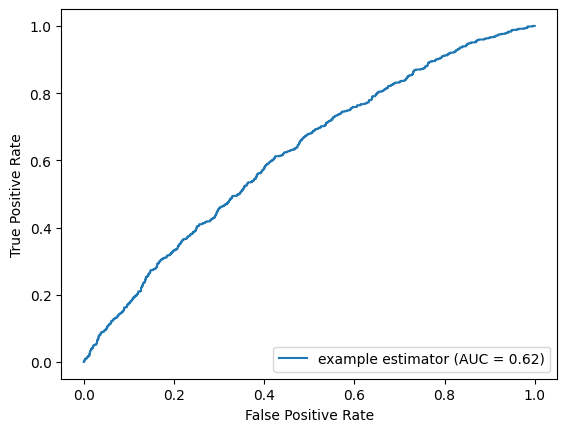

In [42]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds  = roc_curve(df_test['trigger'].astype(int), test_pred_tri_full_original)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()

Examples of model's outputs for emotions and triggers.

In [43]:
print(test_pred_emo_full[:100])
print(test_pred_tri_full[:100])

[4 4 4 5 6 4 1 5 4 4 4 5 6 4 1 5 4 4 3 6 3 4 4 0 0 4 4 5 6 0 4 4 5 6 5 0 5
 4 5 4 4 4 4 4 3 0 0 0 4 4 4 4 3 4 3 2 4 5 6 4 3 3 3 3 3 3 3 4 4 4 4 6 4 3
 3 3 3 3 3 3 4 4 4 4 6 3 3 6 4 6 4 3 3 3 3 3 4 4 6 4]
[0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0.]


In [44]:
# free memory by deleting the model's reference
del model_full
gc.collect()
torch.cuda.empty_cache()

## Execution - Freezed Bert's Embedding Layers

In [45]:
#execute
model_freezed, tokenizer_freezed, statistics_freezed = execute(lr, epochs, batch_size, criterion, num_labels_emo, num_labels_tri, df_train, df_train_labels_emo, df_train_labels_tri, df_val, df_val_labels_emo, df_val_labels_tri, model_name=model_checkpoint, freeze_embeddings=True, weighted_sampling=weighted_sampling, trig_weight=trig_weight)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


input shape: (27964, 151)
input shape: (3519, 151)
ENCODING COMPLETE.
STARTING TRAINING with complete data:


  0%|          | 0/874 [00:00<?, ?it/s]<ipython-input-26-4004cf27e00a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 874/874 [11:46<00:00,  1.24it/s, loss=0.997]


Epoch: 1  Lr: 0.00005000  Loss: Train = [1.4761] - Val = [1.2588]  Time one epoch (s): 740.5829 


Epoch 2: 100%|██████████| 874/874 [11:49<00:00,  1.23it/s, loss=1.13]


Epoch: 2  Lr: 0.00005000  Loss: Train = [0.7986] - Val = [0.9881]  Time one epoch (s): 743.1560 


Epoch 3: 100%|██████████| 874/874 [11:49<00:00,  1.23it/s, loss=0.446]


Epoch: 3  Lr: 0.00005000  Loss: Train = [0.6198] - Val = [0.9226]  Time one epoch (s): 742.9159 


Epoch 4: 100%|██████████| 874/874 [11:49<00:00,  1.23it/s, loss=0.616]


Epoch: 4  Lr: 0.00005000  Loss: Train = [0.5224] - Val = [0.9166]  Time one epoch (s): 742.6814 


Epoch 5: 100%|██████████| 874/874 [11:48<00:00,  1.23it/s, loss=0.629]


Epoch: 5  Lr: 0.00005000  Loss: Train = [0.4792] - Val = [0.9571]  Time one epoch (s): 742.4512 
Early Stopping. Best epoch: 4
Time for 8 epochs (s): 3738.132
TRAINING COMPLETE.


### Evaluation

In [46]:
test_pred_emo_freezed, test_pred_tri_freezed, test_pred_tri_freezed_original = evaluate(model_freezed, test_dataloader, trigger_th=0.5)

0it [00:00, ?it/s]<ipython-input-26-4004cf27e00a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
110it [00:35,  3.08it/s]


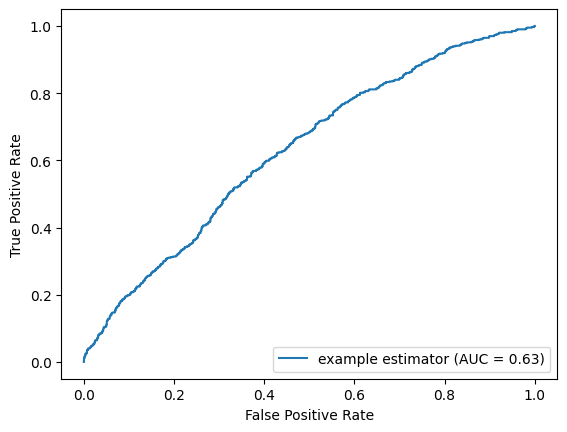

In [47]:
fpr, tpr, thresholds  = roc_curve(df_test['trigger'].astype(int), test_pred_tri_freezed_original)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()

In [48]:
# free memory by deleting the model's reference
del model_freezed
gc.collect()
torch.cuda.empty_cache()

## Reports
Evaluate the models by using the Sequence F1 and the Unrolled Sequence F1 scores. The Sequence Score is calculated dialogue-wise and then averaged, while the Unrolled F1 score is based on all the test results.

The list of models that will be tested: Random, Majority, BERT Fully Finetuned, Bert with Freezed Embedding Layers.

In [49]:
from sklearn.metrics import f1_score

def sequence_f1(data: pd.DataFrame):
  '''input data has columns: episode, utterance, emotion, trigger, labemo, labtri, predicted_emo, predicted_tri
      ground truth:   labemo, labtri
      predicted:      predicted_emo, predicted_tri

      we calculate the F1 scores dialogue-wise, and then return the average'''

  scores_emo = []
  scores_tri = []

  for ep in data['episode'].unique():
    ep_data = data[data['episode'] == ep]

    y_true = ep_data['labemo']
    y_pred = ep_data['predicted_emo']
    # TODO: I don't like -> data['labemo'].unique() => we should change it
    scores_emo.append(f1_score(y_true, y_pred, labels=data['labemo'].unique(), average='micro'))

    y_true = ep_data['trigger']
    y_pred = ep_data['predicted_tri']
    # TODO: I don't like -> data['labemo'].unique() => we should change it
    scores_tri.append(f1_score(y_true, y_pred, labels=data['trigger'].unique(), average='micro'))
  return np.mean(scores_emo), np.mean(scores_tri)

def unrolled_f1(data: pd.DataFrame):
  '''input data has columns: episode, utterance, emotion, trigger, labemo, labtri, predicted_emo, predicted_tri
      ground truth:   labemo, labtri
      predicted:      predicted_emo, predicted_tri

      we calculate the F1 scores on the whole dataset'''
  y_true = data['labemo']
  y_pred = data['predicted_emo']
  # TODO: I don't like -> data['labemo'].unique() => we should change it
  # TODO: Is it ok if we do 'macro' average?
  f1_emotion = f1_score(y_true, y_pred, labels=data['labemo'].unique(), average='macro')

  y_true = data['trigger']
  y_pred = data['predicted_tri']
  # TODO: I don't like -> data['labemo'].unique() => we should change it
  # TODO: Is it ok if we do 'macro' average?
  f1_trigger = f1_score(y_true, y_pred, labels=data['trigger'].unique(), average='macro')
  return f1_emotion, f1_trigger

def unrolled_f1micro(data: pd.DataFrame):
  '''input data has columns: episode, utterance, emotion, trigger, labemo, labtri, predicted_emo, predicted_tri
      ground truth:   labemo, labtri
      predicted:      predicted_emo, predicted_tri

      we calculate the F1 scores on the whole dataset'''
  y_true = data['labemo']
  y_pred = data['predicted_emo']
  # TODO: I don't like -> data['labemo'].unique() => we should change it
  # TODO: Is it ok if we do 'macro' average?
  f1_emotion = f1_score(y_true, y_pred, labels=data['labemo'].unique(), average='micro')

  y_true = data['trigger']
  y_pred = data['predicted_tri']
  # TODO: I don't like -> data['labemo'].unique() => we should change it
  # TODO: Is it ok if we do 'macro' average?
  f1_trigger = f1_score(y_true, y_pred, labels=data['trigger'].unique(), average='micro')
  return f1_emotion, f1_trigger

def complete_f1_report(data: pd.DataFrame, model_str: str):
  print("F1 score report - {}".format(model_str))
  print()
  print("Average Sequence F1 score micro")
  s_e, s_t = sequence_f1(data)
  print("- - Emotion average F1 Score:\t{}".format(s_e))
  print("- - Triggers average F1 Score:\t{}".format(s_t))
  print()
  print("Unrolled Sequence F1 score micro")
  um_e, um_t = unrolled_f1micro(data)
  print("- - Emotion average F1 Score:\t{}".format(um_e))
  print("- - Triggers average F1 Score:\t{}".format(um_t))
  print()
  print("Unrolled Sequence F1 score macro")
  us_e, us_t = unrolled_f1(data)
  print("- - Emotion average F1 Score:\t{}".format(us_e))
  print("- - Triggers average F1 Score:\t{}".format(us_t))
  scores = {'s_e' : s_e,
            's_t' : s_t,
            'us_e' : us_e,
            'us_t' : us_t,
            'um_e': um_e,
            'um_t': um_t}
  return scores

In [50]:
def update_count_dictionary(key:str, d_em:dict):
    ''' Given in input a dictionary and a string key, it counts the times
        that key has been added.'''
    if key in d_em.keys():
        d_em[key] += 1
    else:
        d_em[key] = 1

raw_emotions_dict = dict()
[update_count_dictionary(emotion, raw_emotions_dict) for emotion in df_train['emotion']]
raw_emotions_dict

{'neutral': 12148,
 'surprise': 3702,
 'fear': 893,
 'sadness': 2121,
 'joy': 5063,
 'disgust': 862,
 'anger': 3175}

In [51]:
emotions_dict = dict()
[update_count_dictionary(emotion, emotions_dict) for emotion in df_train['labemo']]
emotions_dict

{4: 12148, 6: 3702, 2: 893, 5: 2121, 3: 5063, 1: 862, 0: 3175}

### Baseline: Random Classifier

In [52]:
class Random_Classifier():
    '''It is trained on a dataset using the emotion and trigger columns.
        It's output on the forward method will be always a random emotion
        and trigger.'''

    def __init__(self):
        self.emotions = []
        self.triggers = []

    def train(self, dataset:pd.DataFrame):
        '''Input a dataset with the emotion and trigger columns.'''

        emotions = dict()
        triggers = dict()

        for em, tr in dataset[['labemo','trigger']].values:
            update_count_dictionary(em, emotions)
            update_count_dictionary(tr, triggers)

        self.emotions = [d for d in emotions.keys()]
        self.triggers = [d for d in triggers.keys()]
        self.n_em = len(self.emotions)
        self.n_tr = len(self.triggers)


    def forward(self, dataset: pd.DataFrame):
        '''The input is ignored. This method can be modified. It is intended to
            mimic the forward method of an ML model such that it usable in the same way.'''
        return [np.random.choice(self.emotions) for row in range(dataset.shape[0])], [np.random.choice(self.triggers) for row in range(dataset.shape[0])]


dumb_random = Random_Classifier()
dumb_random.train(df_train)

print("A test for the dumb random classifier:")
print("\t\tinput: Oh God! I'm dumb..")

e, t = dumb_random.forward(pd.DataFrame(["Oh God! I'm dumb.."]))
print("\t\toutput: emotion:{}, trigger:{}".format(e,t))

A test for the dumb random classifier:
		input: Oh God! I'm dumb..
		output: emotion:[6], trigger:[True]


In [53]:
random_pred_emo = []
random_pred_tri = []
e, t = dumb_random.forward(df_test)
df_test.loc[:,('predicted_emo')] = e
df_test.loc[:,('predicted_tri')] = t
df_test.head(5)

<ipython-input-53-ee1b1f393093>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,('predicted_emo')] = e
<ipython-input-53-ee1b1f393093>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,('predicted_tri')] = t


,episode,utterance,history,future,emotion,trigger,labemo,predicted_emo,predicted_tri
77,utterance_12,"Hey, Mon.",,Hey-hey-hey. You wanna hear something that sucks.,neutral,False,4,4,True
78,utterance_12,Hey-hey-hey. You wanna hear something that sucks.,"Hey, Mon.",Do I ever.,neutral,False,4,5,False
79,utterance_12,Do I ever.,"Hey, Mon. Hey-hey-hey. You wanna hear somethin...",Chris says they're closing down the bar.,joy,False,3,6,True
80,utterance_12,Chris says they're closing down the bar.,Hey-hey-hey. You wanna hear something that suc...,No way!,sadness,True,5,1,True
81,utterance_12,No way!,Do I ever. Chris says they're closing down the...,"Yeah, apparently they're turning it into some ...",surprise,False,6,3,False


In [54]:
rand_scores = complete_f1_report(df_test, "Random classifier")

F1 score report - Random classifier

Average Sequence F1 score micro
- - Emotion average F1 Score:	0.1492116793800567
- - Triggers average F1 Score:	0.5126785772295935

Unrolled Sequence F1 score micro
- - Emotion average F1 Score:	0.14899061700312766
- - Triggers average F1 Score:	0.5063974978675007

Unrolled Sequence F1 score macro
- - Emotion average F1 Score:	0.12613540583669144
- - Triggers average F1 Score:	0.44270237745774565


### Baseline: Majority Classifier

In [55]:
class Majority_Classifier():
    '''It is trained on a dataset using the emotion and trigger columns.
        It's output on the forward method will be always the majority class
        for emotion and trigger, calculated in the training set.'''

    def __init__(self):
        self.emotion = None
        self.trigger = None

    def train(self, dataset:pd.DataFrame):
        '''Input a dataset with the emotion and trigger columns.'''

        emotions_count = dict()
        triggers_count = dict()

        for em, tr in dataset[['labemo','trigger']].values:
            update_count_dictionary(em, emotions_count)
            update_count_dictionary(tr, triggers_count)

        # get the majority class for the emotion column
        max_count = -1
        for emotion, value in emotions_count.items():
            if value > max_count:
                max_count = value
                self.emotion = emotion

        # get the majority class for the trigger column
        max_count = -1
        for trigger, value in triggers_count.items():
            if value > max_count:
                max_count = value
                self.trigger = trigger

    def forward(self, utterance):
        '''The input is ignored. This method can be modified. It is intended to
            mimic the forward method of an ML model such that it usable in the same way.'''
        return self.emotion, self.trigger

    def forward(self, dataset: pd.DataFrame):
        '''The input is ignored. This method can be modified. It is intended to
            mimic the forward method of an ML model such that it usable in the same way.'''

        return [self.emotion for row in range(dataset.shape[0])], [self.trigger for row in range(dataset.shape[0])]


dumb_majority = Majority_Classifier()
dumb_majority.train(df_train)

print("The majority emotion is: {}".format(dumb_majority.emotion))
print("The majority trigger is: {}".format(dumb_majority.trigger))
print()
print("A test for the dumb majority classifier:")
print("\t\tinput: Oh God! I'm dumb..")

e, t = dumb_majority.forward(pd.DataFrame(["Oh God! I'm dumb.."]))
print("\t\toutput: emotion:{}, trigger:{}".format(e,t))

The majority emotion is: 4
The majority trigger is: False

A test for the dumb majority classifier:
		input: Oh God! I'm dumb..
		output: emotion:[4], trigger:[False]


In [56]:
majority_pred_emo = []
majority_pred_tri = []
e, t = dumb_majority.forward(df_test)
df_test.loc[:,('predicted_emo')] = e
df_test.loc[:,('predicted_tri')] = t
df_test.head(5)

<ipython-input-56-ad285f55e64d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,('predicted_emo')] = e
<ipython-input-56-ad285f55e64d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,('predicted_tri')] = t


,episode,utterance,history,future,emotion,trigger,labemo,predicted_emo,predicted_tri
77,utterance_12,"Hey, Mon.",,Hey-hey-hey. You wanna hear something that sucks.,neutral,False,4,4,False
78,utterance_12,Hey-hey-hey. You wanna hear something that sucks.,"Hey, Mon.",Do I ever.,neutral,False,4,4,False
79,utterance_12,Do I ever.,"Hey, Mon. Hey-hey-hey. You wanna hear somethin...",Chris says they're closing down the bar.,joy,False,3,4,False
80,utterance_12,Chris says they're closing down the bar.,Hey-hey-hey. You wanna hear something that suc...,No way!,sadness,True,5,4,False
81,utterance_12,No way!,Do I ever. Chris says they're closing down the...,"Yeah, apparently they're turning it into some ...",surprise,False,6,4,False


In [57]:
maj_scores = complete_f1_report(df_test, "Majority classifier")

F1 score report - Majority classifier

Average Sequence F1 score micro
- - Emotion average F1 Score:	0.424671419276346
- - Triggers average F1 Score:	0.7882678378697737

Unrolled Sequence F1 score micro
- - Emotion average F1 Score:	0.43161785612738135
- - Triggers average F1 Score:	0.8313903895365368

Unrolled Sequence F1 score macro
- - Emotion average F1 Score:	0.08613987799687899
- - Triggers average F1 Score:	0.4539667753454433


### Actual model - Fully finetuned

In [58]:
df_test_full = df_test.copy()
df_test_full.loc[:,('predicted_emo')] = test_pred_emo_full
df_test_full.loc[:,('predicted_tri')] = test_pred_tri_full.astype(bool)
df_test_full.head(5)

sdir = os.path.join(results_folder, f"{SEED}_full_pred.csv")
df_test_full.to_csv(sdir, index=False, header=True)

In [59]:
bert_full_scores = complete_f1_report(df_test_full, "Bert Fully finetuned")

F1 score report - Bert Fully finetuned

Average Sequence F1 score micro
- - Emotion average F1 Score:	0.9204089387564619
- - Triggers average F1 Score:	0.6551542808761099

Unrolled Sequence F1 score micro
- - Emotion average F1 Score:	0.9260733579755474
- - Triggers average F1 Score:	0.6593687802104066

Unrolled Sequence F1 score macro
- - Emotion average F1 Score:	0.9083721473526346
- - Triggers average F1 Score:	0.5422467485285375


### Actual model - Freezed Embedding Layers

In [60]:
df_test_freezed = df_test.copy()
df_test_freezed.loc[:,('predicted_emo')] = test_pred_emo_freezed
df_test_freezed.loc[:,('predicted_tri')] = test_pred_tri_freezed.astype(bool)
df_test_freezed.head(5)

sdir = os.path.join(results_folder, f"{SEED}_freezed_pred.csv")
df_test_freezed.to_csv(sdir, index=False, header=True)

In [61]:
bert_freezed_scores = complete_f1_report(df_test_freezed, "Bert with Freezed Embedding layer")

F1 score report - Bert with Freezed Embedding layer

Average Sequence F1 score micro
- - Emotion average F1 Score:	0.9177869262230718
- - Triggers average F1 Score:	0.6664000774416837

Unrolled Sequence F1 score micro
- - Emotion average F1 Score:	0.931191356269548
- - Triggers average F1 Score:	0.6698891100369633

Unrolled Sequence F1 score macro
- - Emotion average F1 Score:	0.9110399571815819
- - Triggers average F1 Score:	0.543608662280959


###Summary

A summary of the previous results is saved in a CSV file (SEED-specific) for further analysis.

In [62]:
s_e = [rand_scores['s_e'],maj_scores['s_e'],bert_full_scores['s_e'],bert_freezed_scores['s_e']]
s_t = [rand_scores['s_t'],maj_scores['s_t'],bert_full_scores['s_t'],bert_freezed_scores['s_t']]
us_e =[rand_scores['us_e'],maj_scores['us_e'],bert_full_scores['us_e'],bert_freezed_scores['us_e']]
us_t =[rand_scores['us_t'],maj_scores['us_t'],bert_full_scores['us_t'],bert_freezed_scores['us_t']]
um_e =[rand_scores['um_e'],maj_scores['um_e'],bert_full_scores['um_e'],bert_freezed_scores['um_e']]
um_t =[rand_scores['um_t'],maj_scores['um_t'],bert_full_scores['um_t'],bert_freezed_scores['um_t']]

final_result = {'Sequence F1 emotions micro' : s_e,
                'Sequence F1 triggers micro': s_t,
                'Unrolled Sequence F1 emotions micro':um_e,
                'Unrolled Sequence F1 triggers micro':um_t,
                'Unrolled Sequence F1 emotions macro':us_e,
                'Unrolled Sequence F1 triggers macro':us_t,
                }

In [63]:
df_results = pd.DataFrame.from_dict(final_result,orient = 'index', columns = ['Random Classifier', 'Majority Classifier','Bert Full','Bert Freezed'])
df_results

,Random Classifier,Majority Classifier,Bert Full,Bert Freezed
Sequence F1 emotions micro,0.149212,0.424671,0.920409,0.917787
Sequence F1 triggers micro,0.512679,0.788268,0.655154,0.666400
Unrolled Sequence F1 emotions micro,0.148991,0.431618,0.926073,0.931191
Unrolled Sequence F1 triggers micro,0.506397,0.831390,0.659369,0.669889
Unrolled Sequence F1 emotions macro,0.126135,0.086140,0.908372,0.911040
Unrolled Sequence F1 triggers macro,0.442702,0.453967,0.542247,0.543609


In [64]:
results_to_csv(df_results,SEED)
r = results_from_csv(SEED)
r

,Unnamed: 0,Random Classifier,Majority Classifier,Bert Full,Bert Freezed
0,Sequence F1 emotions micro,0.149212,0.424671,0.920409,0.917787
1,Sequence F1 triggers micro,0.512679,0.788268,0.655154,0.666400
2,Unrolled Sequence F1 emotions micro,0.148991,0.431618,0.926073,0.931191
3,Unrolled Sequence F1 triggers micro,0.506397,0.831390,0.659369,0.669889
4,Unrolled Sequence F1 emotions macro,0.126135,0.086140,0.908372,0.911040
5,Unrolled Sequence F1 triggers macro,0.442702,0.453967,0.542247,0.543609


## Error analysis

In [65]:
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

def get_report(data: pd.DataFrame, label: str):
  '''input data has columns: lab{label}, predicted_{label}
      label: selected label

      Calculates the confusion matrix and a report dataframe is returned
      '''

  y_true = data["trigger"] if label=="tri" else le_emo.inverse_transform(data["labemo"])
  y_pred = data["predicted_tri"] if label=="tri" else le_emo.inverse_transform(data[f'predicted_emo'])
  labels = data["trigger"].unique() if label=="tri" else le_emo.inverse_transform(data["labemo"].unique())

  report = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)

  df_report = pd.DataFrame.from_records(report).transpose()

  df_report.drop(["precision", "recall"], axis=1, inplace=True)
  df_report.drop(["accuracy", "weighted avg", "macro avg"], axis=0, inplace=True)
  df_report["encoded_label"] = df_report.index if label=="tri" else le_emo.transform(df_report.index)
  df_report["label"] = df_report.index
  df_report = df_report.reset_index(drop=True)
  cm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
  cm_disp = ConfusionMatrixDisplay(cm, display_labels=labels)

  return df_report, cm_disp

In [66]:
df_rep_emotion_full, cm_disp_full = get_report(df_test_full, 'emo')
df_rep_emotion_freezed, cm_disp_freezed = get_report(df_test_freezed, 'emo')

In [67]:
df_rep_emotion_full

,f1-score,support,encoded_label,label
0,0.890889,429.0,0,anger
1,0.918919,96.0,1,disgust
2,0.871111,114.0,2,fear
3,0.916735,622.0,3,joy
4,0.953222,1518.0,4,neutral
5,0.890625,269.0,5,sadness
6,0.917104,469.0,6,surprise


### Support and F1 score - Fully finetuned

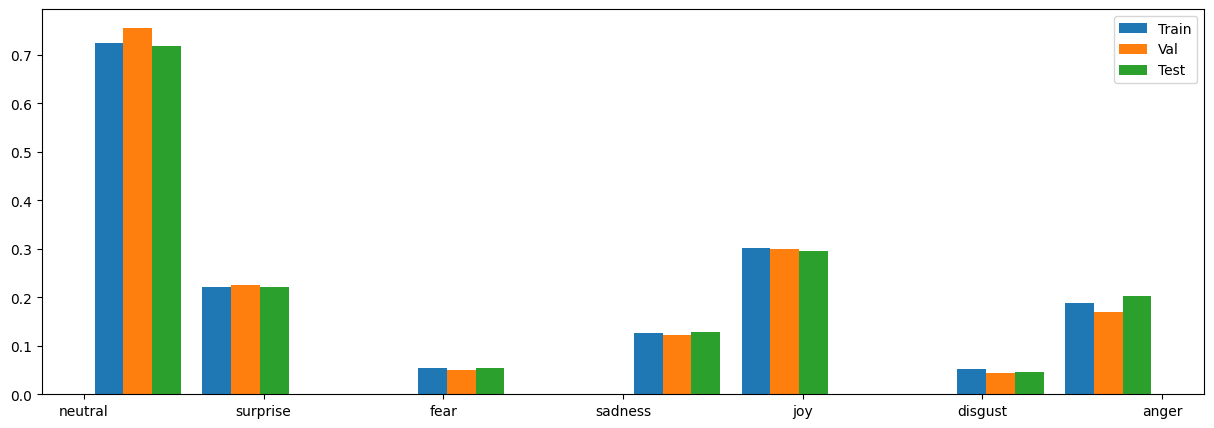

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.hist([df_train.emotion, df_val.emotion, df_test_full.emotion],
                density=True,
                label=["Train", "Val", "Test"],
                histtype="bar",
                )
plt.legend()
plt.show()

<ipython-input-69-baa0bff2c4b4>:4: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  df_rep_emotion_full.plot(x="label", y="f1-score", kind="bar", sort_columns=True)


<Figure size 1500x200 with 0 Axes>

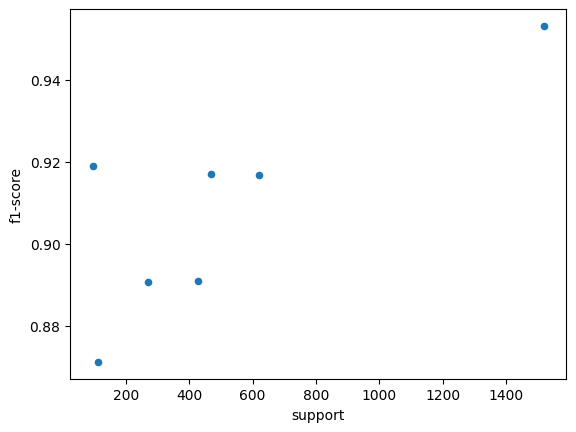

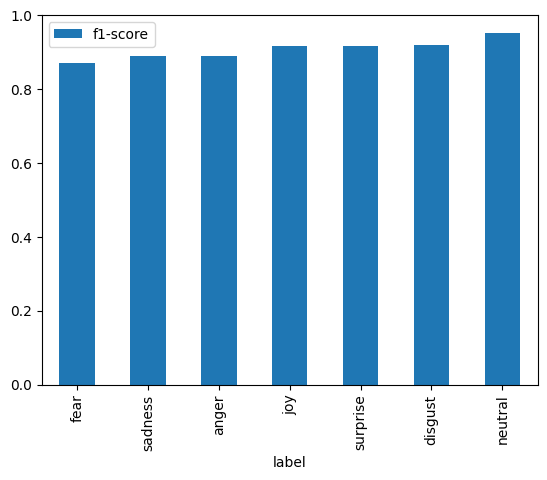

In [69]:
plt.figure(figsize=(15,2))
df_rep_emotion_full.plot.scatter(x="support", y="f1-score")
df_rep_emotion_full.sort_values("f1-score", inplace= True)
df_rep_emotion_full.plot(x="label", y="f1-score", kind="bar", sort_columns=True)
plt.show()

### Confusion Matrix - Fully finetuned

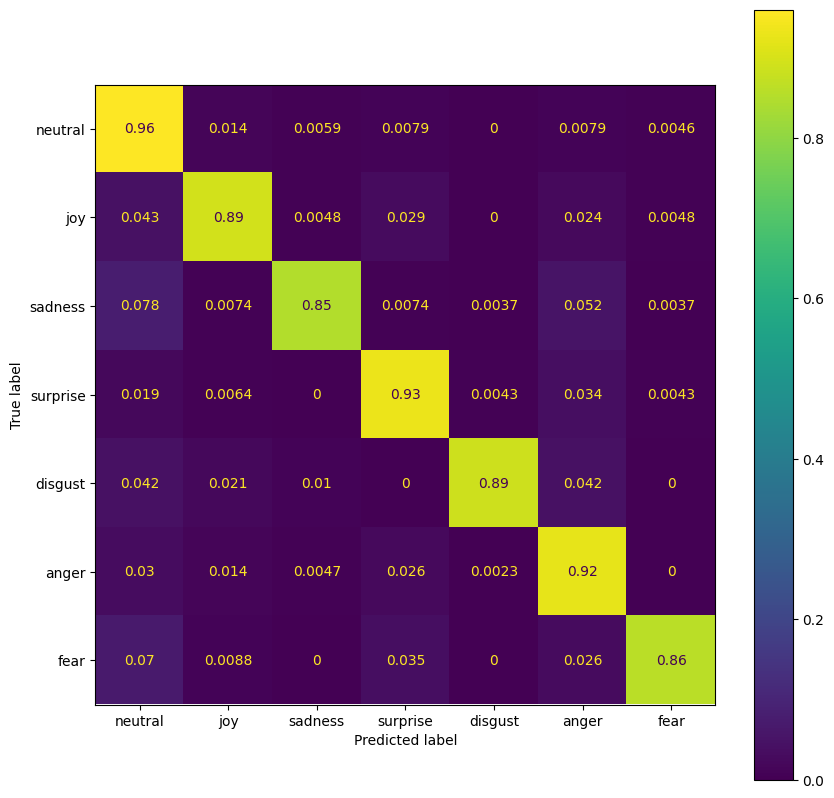

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
cm_disp_full.plot(ax=ax)

### Support and F1 score - Freezed finetuned

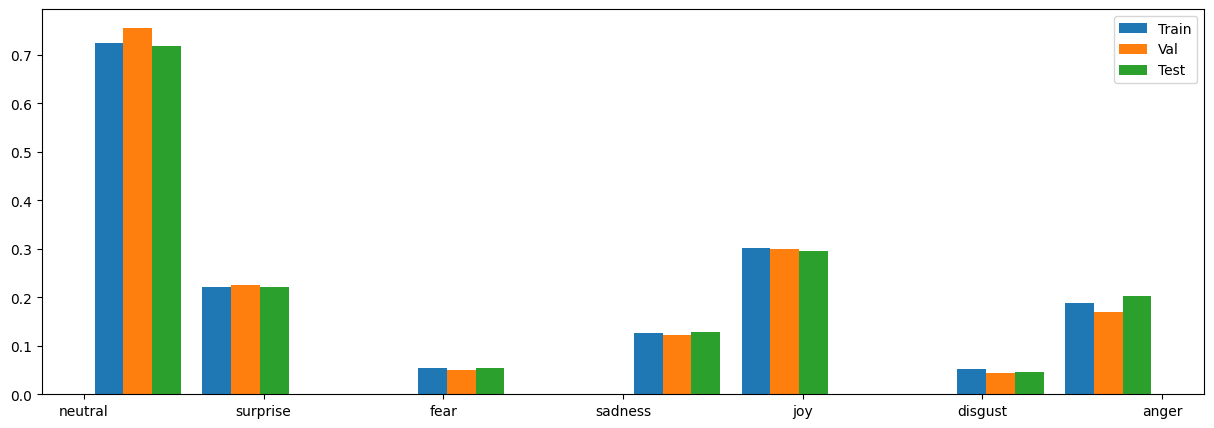

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.hist([df_train.emotion, df_val.emotion, df_test_freezed.emotion],
                density=True,
                label=["Train", "Val", "Test"],
                histtype="bar",
                )
plt.legend()
plt.show()

<ipython-input-72-2a1ce6c817aa>:4: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  df_rep_emotion_freezed.plot(x="label", y="f1-score", kind="bar", sort_columns=True)


<Figure size 1500x200 with 0 Axes>

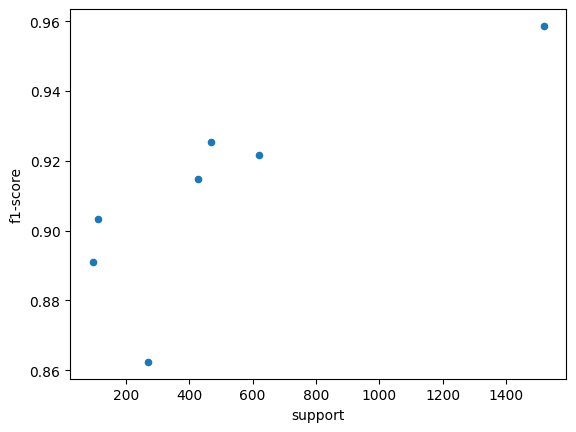

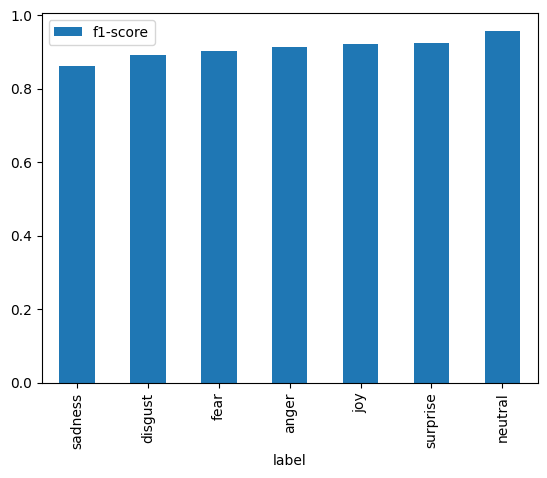

In [72]:
plt.figure(figsize=(15,2))
df_rep_emotion_freezed.plot.scatter(x="support", y="f1-score")
df_rep_emotion_freezed.sort_values("f1-score", inplace= True)
df_rep_emotion_freezed.plot(x="label", y="f1-score", kind="bar", sort_columns=True)
plt.show()

### Confusion Matrix - Freezed finetuned

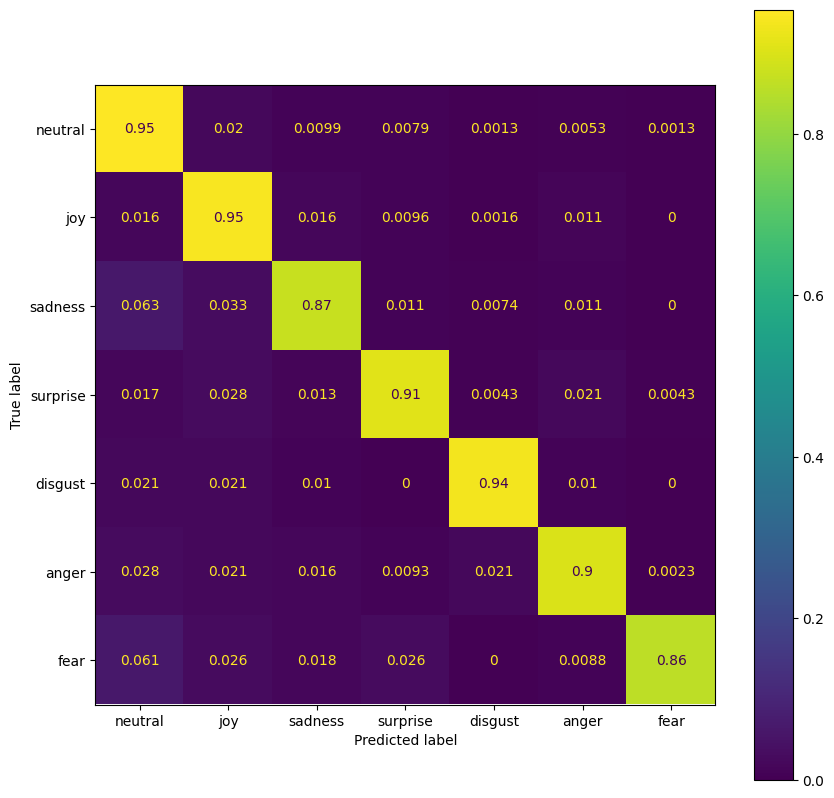

In [73]:
fig, ax = plt.subplots(figsize=(10,10))
cm_disp_freezed.plot(ax=ax)

### Triggers error

In [74]:
df_report_tri_full, cm_disp_full = get_report(df_test_full, 'tri')
df_report_tri_freezed, cm_disp_freezed = get_report(df_test_freezed, 'tri')

#### Fully Finetuned

In [75]:
df_report_tri_full

,f1-score,support,encoded_label,label
0,0.773792,2924.0,False,False
1,0.310702,593.0,True,True


#### Freezed Finetuned

In [76]:
df_report_tri_freezed

,f1-score,support,encoded_label,label
0,0.783678,2924.0,False,False
1,0.303539,593.0,True,True


The trigger for its nature is quite rare in the dataset and it requires a deeply understanding of the meaning of the sentence. So it doesn't surprise to see that's it's more difficult for the model to be identified.

#### Fully finetuned CM

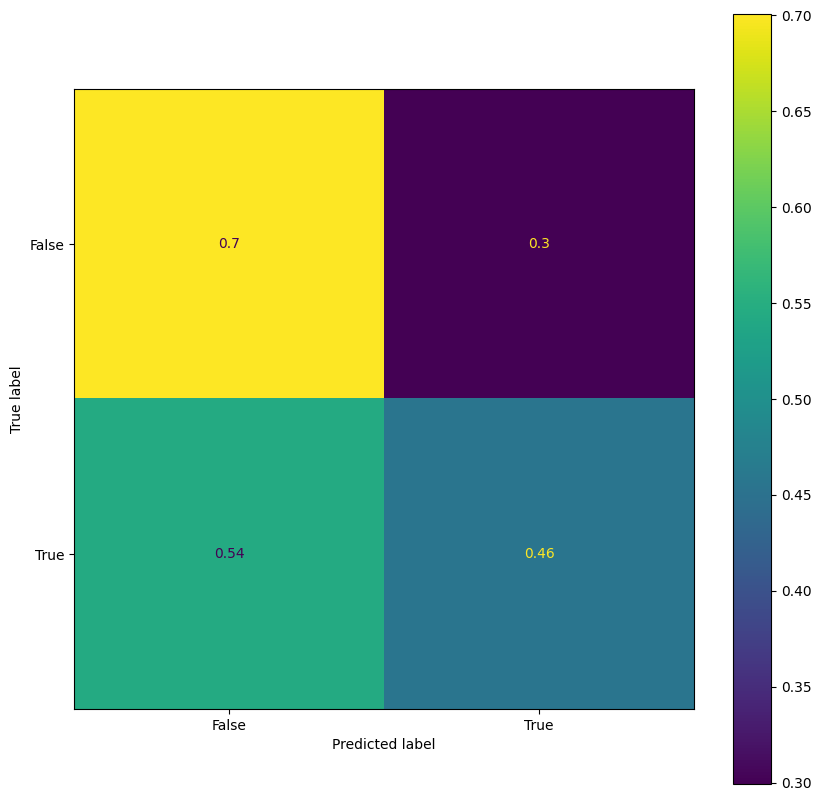

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
cm_disp_full.plot(ax=ax)

#### Freezed finetuned CM

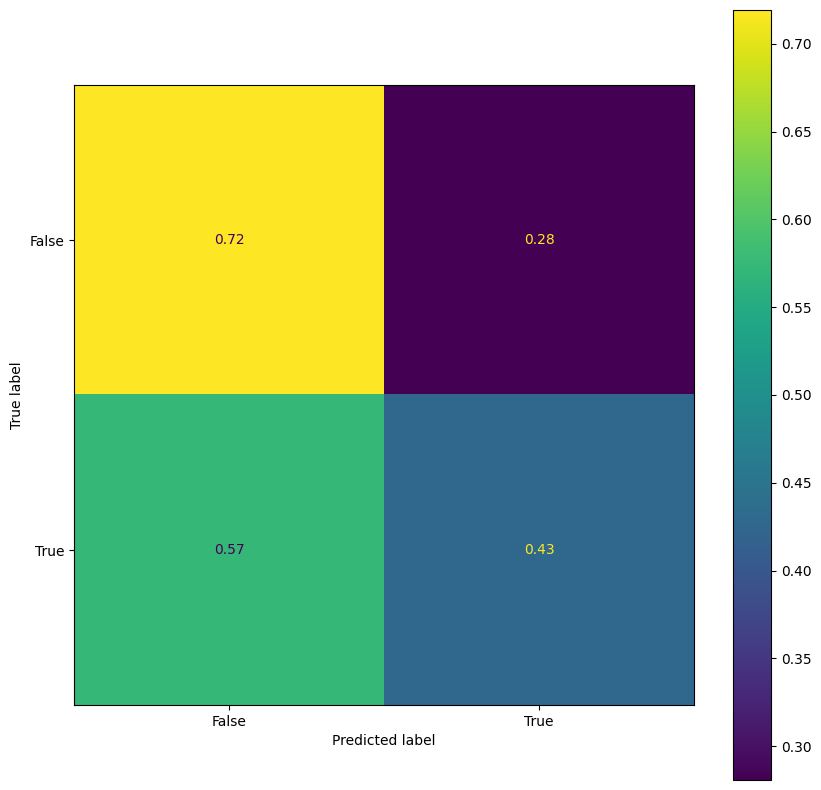

In [78]:
fig, ax = plt.subplots(figsize=(10,10))
cm_disp_freezed.plot(ax=ax)

For the triggers analysis, it could be usefull to observe if there are emotion for which an error is more frequent

First of all, let's show the frequence of triggers related to the emotion

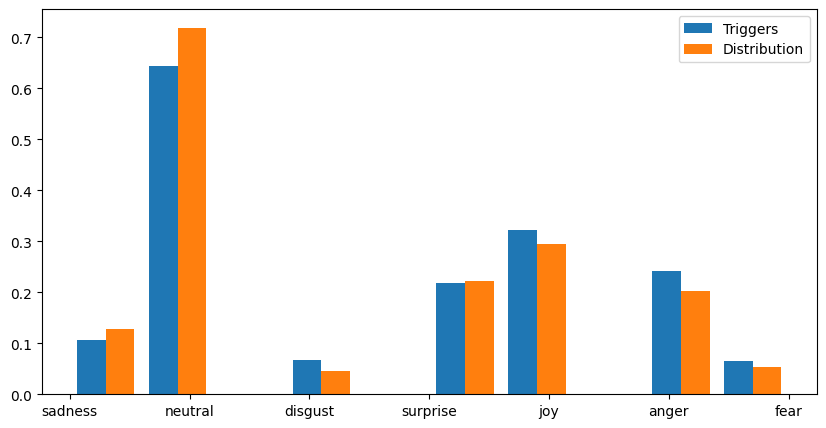

In [79]:
df_report_tri = df_test[df_test["trigger"] == 1]
plt.figure(figsize=(10,5))
plt.hist([df_report_tri.emotion, df_test.emotion],
                density=True,
                label=["Triggers", "Distribution"],
                histtype="bar",
                )

plt.legend()
plt.show()

The triggers are well distributed among the emotions.

#### Fully finetuned

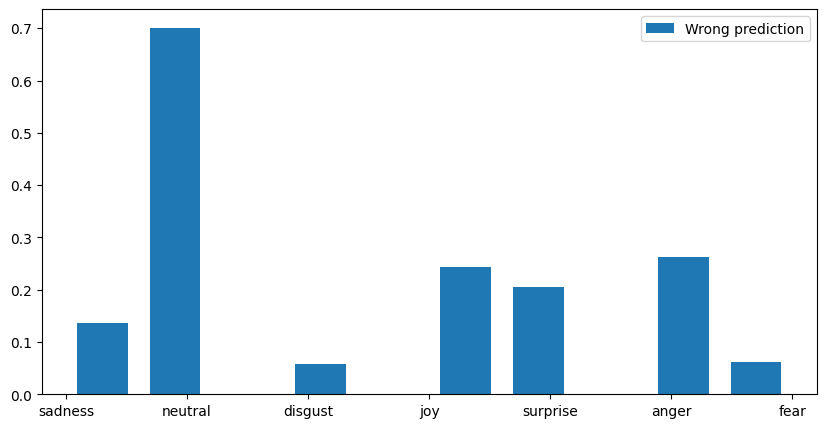

In [80]:
df_report_tri_full = df_test_full[df_test_full["trigger"] != df_test_full["predicted_tri"]]
plt.figure(figsize=(10,5))
plt.hist(df_report_tri_full.emotion,
                density=True,
                label="Wrong prediction",
                histtype="bar",
                rwidth=0.7
                )
plt.legend()
plt.show()

#### Freezed finetuned

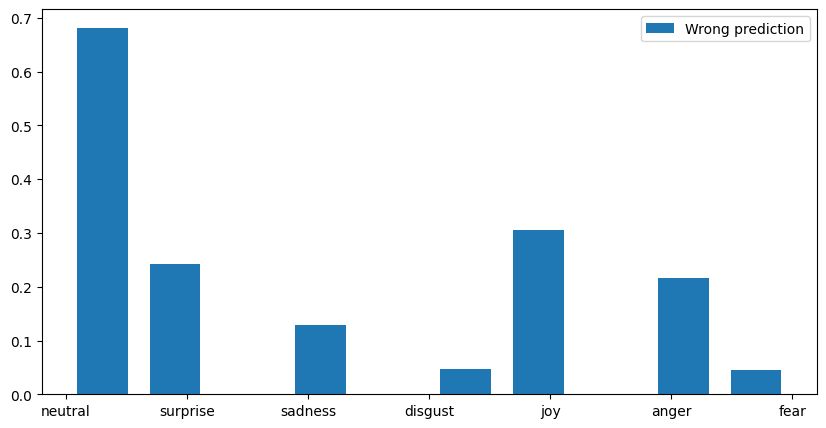

In [81]:
df_report_tri_freezed = df_test_freezed[df_test_freezed["trigger"] != df_test_freezed["predicted_tri"]]
plt.figure(figsize=(10,5))
plt.hist(df_report_tri_freezed.emotion,
                density=True,
                label="Wrong prediction",
                histtype="bar",
                rwidth=0.7
                )
plt.legend()
plt.show()